In [151]:
import os
import re
import tkinter as tk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

In [152]:
class Parameters():
    """Parameters of the model."""

    def __init__(self):
        self.wintemp = tk.Tk()
        self.wintemp.title('Parameters')
        self.wintemp.geometry('300x150')
        self.wintemp.configure(background='gray91')
        self.get_language = tk.StringVar()
        self.language = []
        self.get_data = tk.StringVar()
        self.dat = []
        self.lan = os.listdir(os.getcwd() + '/languages/')
        self.dat = os.listdir(os.getcwd() + '/data/') 
        self.label1 = tk.Label(self.wintemp, text='Language:', bg='gray91')
        self.label1.grid(row=0, column=0, padx=10, pady=10,  sticky='WENS')
        self.lani = tk.OptionMenu(self.wintemp, self.get_language, *self.lan)
        self.lani.grid(row=1, column=0, padx=10, pady=10, sticky='WENS')
        self.label2 = tk.Label(self.wintemp, text='Data:', bg='gray91')
        self.label2.grid(row=0, column=2, padx=10, pady=10, sticky='WENS')
        self.dati = tk.OptionMenu(self.wintemp, self.get_data, *self.dat)
        self.dati.grid(row=1, column=2, padx=10, pady=10, sticky='WENS')
        self.ok = tk.Button(self.wintemp, text='OK', command=self.close)
        self.ok.grid(row=2, column=1, padx=10, pady=10, sticky='WENS')
        self.wintemp.mainloop()

    def store(self):
        """Store variables."""
        self.language = self.get_language.get()
        self.data = self.get_data.get()
        return (self.language, self.data)

    def close(self):
        """Close method."""
        self.store()
        self.wintemp.destroy()


class Load():
    """Load data and files for the language."""

    def __init__(self, lang, dat):
        self.dirstop = (os.getcwd() + '/languages/' + lang + '/stopwords.csv')
        self.dirdat = (os.getcwd() + '/data/' + dat + '/data.csv')
        self.dirmet = (os.getcwd() + '/data/' + dat + '/metadata.csv')
        self.stop = pd.read_csv(self.dirstop, names=['word'],  encoding='utf-8')
        self.stopwords = np.array(self.stop['word'])
        self.data = pd.read_csv(self.dirdat, encoding='utf-8')
        self.metadata = pd.read_csv(self.dirmet, encoding='utf-8')


class Sentiments():
    """Load the lexicon."""

    def __init__(self, lang):
        self.diremo = (os.getcwd() + '/languages/' + lang + '/nrcemo.csv')
        self.dirvad = (os.getcwd() + '/languages/' + lang + '/nrcvad.csv')
        self.nrcemo = pd.read_csv(self.diremo, encoding='utf-8')
        self.nrcvad = pd.read_csv(self.dirvad, encoding='utf-8')
        self.emocol = self.nrcemo.select_dtypes(include=np.number).columns
        self.vadcol = self.nrcvad.select_dtypes(include=np.number).columns
        self.basicemo = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                         'sadness', 'surprise', 'trust']
        self.basicsen = ['positive','negative']


def preprocess(sentence):
    "Preprocess the text."
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '', cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num) 
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords]
    return " ".join(filtered_words)


def calculate_emotions(sentence):
    """Calculate basic emotions"""
    tokenize = RegexpTokenizer(r'\w+')
    tokens = tokenize.tokenize(sentence)
    df= pd.DataFrame()
    for palabra in tokens:
        df = pd.concat([df, datemo.loc[datemo['Word'] == palabra]])
    df = df.sum(axis=0, numeric_only=True)
    df = pd.DataFrame(df)
    df = df.transpose()
    return df


def calculate_valence(sentence):
    """Calculate vad scale."""
    tokenize = RegexpTokenizer(r'\w+')
    tokens = tokenize.tokenize(sentence)
    df= pd.DataFrame()
    for palabra in tokens:
        if datvad['Word'].isin([palabra]).any() == True:
            new = datvad[vadcol].loc[datvad['Word'] == palabra]
            new = new.mean(axis=0)
            df = pd.concat([df, new], axis=1)
    df = df.mean(axis=1, numeric_only=True)
    df = pd.DataFrame(df)
    df = df.transpose()
    return df


def entropy(frm):
    """Calculate shannon entropy of distribution of probabilities."""
    n = frm.shape[1]
    H = -((frm * np.log2(frm+1e-10)).fillna(0).sum(axis=1) / np.log2(n))
    return H


def complexity(frm):
    """Calculate statistical complexity of distribution of probabilities."""
    n = frm.shape[1]
    H = -((frm * np.log2(frm+1e-10)).fillna(0).sum(axis=1) / np.log2(n))
    D = ((sent[emocol] - (1.0 / 8.0)) ** 2.0).sum(axis=1)
    C = H * D
    return C

In [153]:
# Load work parameters and data
Parameters = Parameters()
Sentiments = Sentiments(Parameters.language)
Load = Load(Parameters.language, Parameters.data)
stopwords = Load.stopwords
datemo = Sentiments.nrcemo
datvad = Sentiments.nrcvad
emocol = Sentiments.basicemo
sencol = Sentiments.basicsen
vadcol = Sentiments.vadcol
data = Load.data
metadata = Load.metadata
savefiles = (os.getcwd() + '/results/' + Parameters.data + '/')
if os.path.exists(savefiles) == True:
    print('Directory exists')
else:
    os.mkdir(savefiles)
    print('Results directory was created')

Directory exists


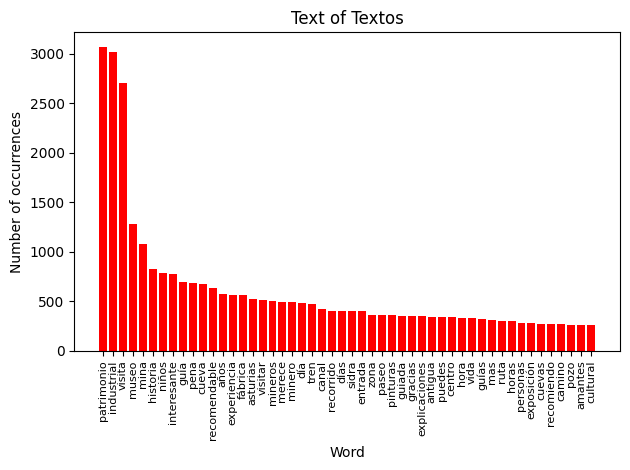

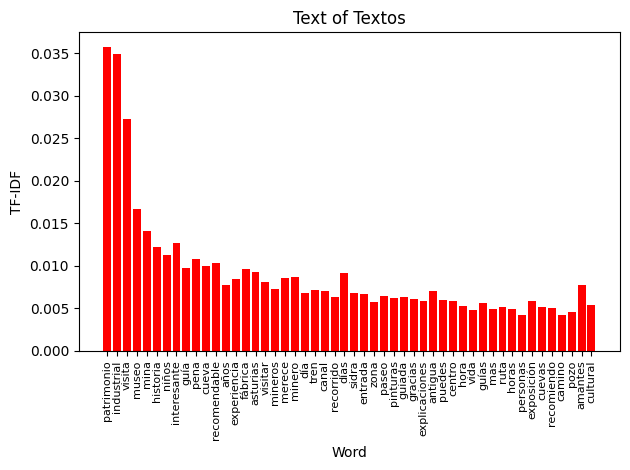

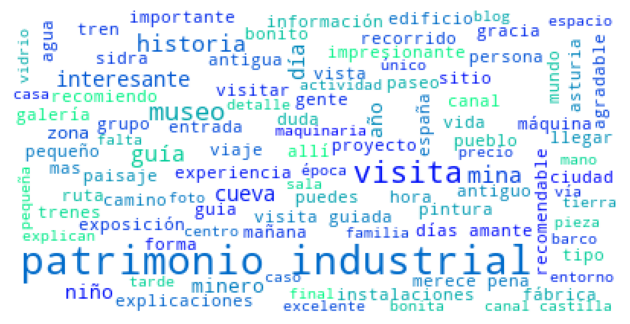

In [154]:
for ind in metadata.index:
    variable = metadata['variable'].loc[ind]
    title = metadata['title'].loc[ind]
    # Counts of words
    data[variable] = data[variable].map(lambda x:preprocess(x))
    cvec = CountVectorizer()
    cvec_counts = cvec.fit_transform(data[variable])
    occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
    counts_df = pd.DataFrame({'term': cvec.get_feature_names_out(), 'occurrences': occ})
    counts_df = counts_df.sort_values(by='occurrences', ascending=False)
    # TF-IDF
    tvec = TfidfVectorizer()
    tvec_weights = tvec.fit_transform(data[variable])
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': tvec.get_feature_names_out(), 'weight': weights})
    weights_df = weights_df.sort_values(by='weight', ascending=False)
    # Merge dataframe and select words for models
    words = pd.merge(counts_df, weights_df,left_on='term', right_on='term')
    words = words.head(50)
    words.to_csv(savefiles + title + '-words.csv', encoding='utf-8', index=False)
    # Plot the frequency
    plt.figure()
    plt.bar(x= words['term'], height=words['occurrences'], color='red')
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("Word")
    plt.ylabel("Number of occurrences")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savefiles + title + '-frequencies.png', transparent=True)
    # Plot the tf-idf
    plt.figure()
    plt.bar(x= words['term'], height=words['weight'], color='red')
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("Word")
    plt.ylabel("TF-IDF")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savefiles + title + '-tf-idf.png', transparent=True)
    #Plot the wordcloud
    plt.figure()
    wordcloud = WordCloud(background_color="white", max_words=100, colormap='winter').generate(" ".join(data[variable]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(savefiles + title + '-worcloud.png', transparent=True)

In [155]:
# PARES DE PALABRAS
#palabras = words.head(25)['term'].tolist()
palabras = ['patrimonio', 'industrial', 'visita', 'museo', 'mina', 'historia', 'niños', 'interesante', 'guía',
            'cueva', 'recomendable', 'experiencia', 'fábrica', 'asturias', 'visitar', 'mineros', 'merece',
            'minero', 'tren', 'canal', 'recorrido', 'sidra', 'entrada', 'zona', 'paseo', 'pinturas']
combinaciones = []
for i in palabras:
    for j in palabras:
        if i==j: continue
        else: combinaciones.append(i+' '+j)

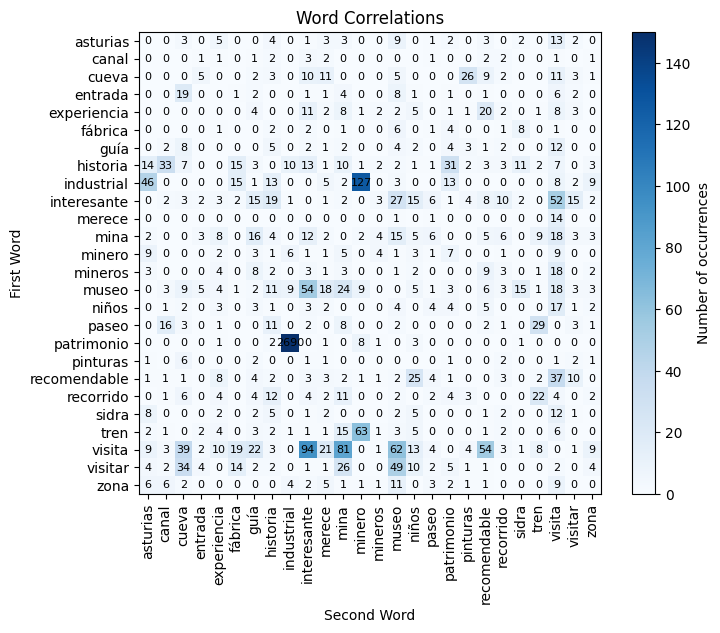

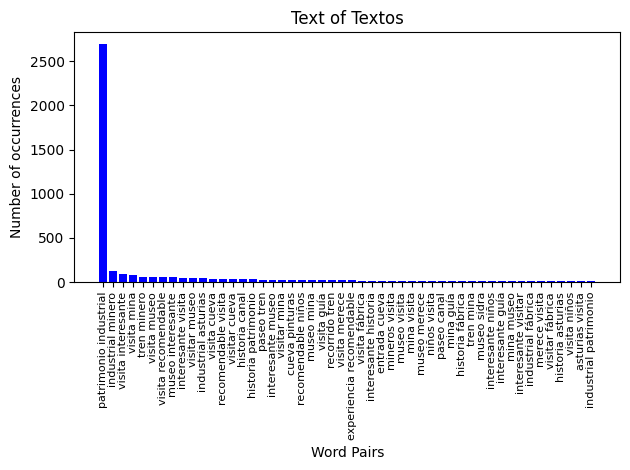

In [156]:
for ind in metadata.index:
    variable = metadata['variable'].loc[ind]
    title = metadata['title'].loc[ind]
    # Counts of words
    data[variable] = data[variable].map(lambda x:preprocess(x))
    cvec = CountVectorizer(ngram_range=(2, 2),vocabulary=combinaciones)
    cvec_counts = cvec.fit_transform(data[variable])
    occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
    counts_df = pd.DataFrame({'term': cvec.get_feature_names_out(), 'occurrences': occ})
    counts_df = counts_df.sort_values(by='occurrences', ascending=False)
    # TF-IDF
    tvec = TfidfVectorizer(ngram_range=(2, 2),vocabulary=combinaciones)
    tvec_weights = tvec.fit_transform(data[variable])
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': tvec.get_feature_names_out(), 'weight': weights})
    weights_df = weights_df.sort_values(by='weight', ascending=False)
    # Merge dataframe and select words for models
    words2 = pd.merge(counts_df,weights_df,left_on='term', right_on='term')
    df_corr = words2.copy()
    words2 = words2.head(50)
    words2.to_csv(savefiles + title + '-word_pairs.csv', encoding='utf-8', index=False)
    
    # Plot the correlations
    df_corr[['first_word', 'second_word']] = df_corr['term'].str.split(expand=True)
    pivot_df = df_corr.pivot(index='first_word', columns='second_word', values='occurrences').fillna(0)
    plt.figure(figsize=(8, 6))
    plt.imshow(pivot_df.values, cmap='Blues', interpolation='nearest',vmax=min(150,pivot_df.max(axis=None)))
    for i in range(len(pivot_df.index)):
        for j in range(len(pivot_df.columns)):
            plt.text(j, i, str(int(pivot_df.values[i, j])), ha='center', va='center',fontsize=8)
    plt.xticks(range(len(pivot_df.columns)), pivot_df.columns,rotation=90)
    plt.yticks(range(len(pivot_df.index)), pivot_df.index)
    plt.colorbar(label='Number of occurrences')
    plt.title('Word Correlations')
    plt.xlabel('Second Word')
    plt.ylabel('First Word')
    plt.savefig(savefiles + title + '-correlations.png', transparent=True)
    
    # Plot the frequency
    plt.figure()
    plt.bar(x= words2['term'], height=words2['occurrences'], color='blue')
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("Word Pairs")
    plt.ylabel("Number of occurrences")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savefiles + title + '-frequencies_pairs.png', transparent=True)


In [150]:
parejas = ['patrimonio industrial', 'industrial minero', 'visita interesante', 'visita mina', 'tren minero', 'visita museo',
           'visita recomendable', 'museo interesante', 'interesante visita', 'visitar museo',  'visita cueva',
           'recomendable visita', 'visitar cueva',    'interesante museo','visitar mina', 'cueva pinturas',
           'recomendable niños', 'museo mina', 'visita guía', 'recorrido tren', 'visita merece',
           'experiencia recomendable', 'visita fábrica', 'interesante historia',  'mineros visita', 'museo visita',
           'mina visita', 'museo merece', 'niños visita', 'paseo canal',  'tren mina', 'museo sidra',
           'interesante niños', 'interesante guía', 'mina museo', 'interesante visitar',  'merece visita',
           'visitar fábrica', 'visita niños']

Calculate basic emotions for Textos
Sentences processed: 1000
Sentences processed: 2000
Sentences processed: 3000
Sentences processed: 4000
Sentences processed: 5000
Sentences processed: 6000
Sentences processed: 7000
Sentences processed: 8000
End of processing for calculate emotions.


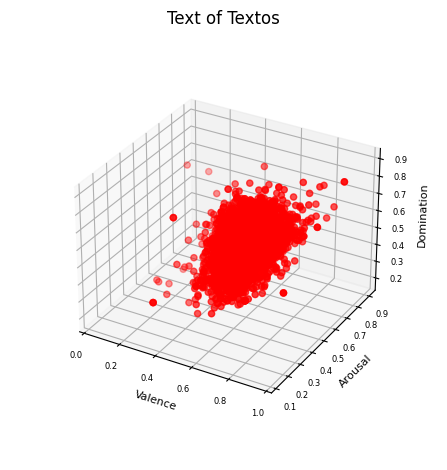

In [40]:
for inj in metadata.index:
    variable = metadata['variable'].loc[inj]
    title = metadata['title'].loc[inj]
    print('Calculate basic emotions for ' + variable)
    sent = pd.DataFrame()
    vad = pd.DataFrame()
    contador = 0
    for i in data[variable]:
        contador = contador + 1
        sent = pd.concat([sent, calculate_emotions(i)])
        vad = pd.concat([vad, calculate_valence(i)])
        if contador % 1000 == 0:
            print('Sentences processed: ' + str(contador))
    print('End of processing for calculate emotions.')
    sent = sent.reset_index(drop=True)
    sent['sum_emotions'] =  sent[emocol].sum(axis=1)
    sent['sum_sentiments'] = sent[sencol].sum(axis=1)
    sent[emocol] = sent[emocol].div(sent['sum_emotions'], axis=0)
    sent[sencol] = sent[sencol].div(sent['sum_sentiments'], axis=0)
    sent.fillna(0)
    sent['polarity'] = sent['positive'] + (-1.00) * sent['negative']
    sent['entropy'] = entropy(sent[emocol])
    sent['complexity'] = complexity(sent[emocol])
    sent[np.append(emocol, ['polarity', 'entropy', 'complexity'])].to_csv(savefiles + title + '-emotions.csv', 
                                                                          encoding='utf-8', index=False)
    vad.to_csv(savefiles + title + '-vad.csv', encoding='utf-8', index=False)
    # VAD space
    plotvar = vad.dropna()
    fig = plt.figure()
    ax = plt.axes(projection ="3d")
    ax.scatter(plotvar['Valence'], plotvar['Arousal'], plotvar['Dominance'], color = "red")
    ax.set_xlabel('Valence', fontsize=8)
    ax.set_ylabel('Arousal', fontsize=8) 
    ax.set_zlabel('Domination',fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both', which='minor', labelsize=6)
    ax.set_box_aspect(aspect=None, zoom=0.8)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(savefiles + title + '-vad_space.png', transparent=True)